# Signal Processing for Vibration Testing

In [47]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import control as ctrl
import matplotlib.pyplot as plt
import vibrationtesting as vt
import numpy as np
import scipy as sp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
sample_freq = 1e3
noise_power = 0.001 * sample_freq / 2
A = sp.array([[0, 0, 1, 0],\
              [0, 0, 0, 1],\
              [-200, 100, -.2, .1],\
              [100, -200, .1, -.2]])
B = sp.array([[0], [0], [1], [0]])
C = sp.array([[35, 0, 0, 0], [0, 35, 0, 0]])
D = sp.array([[0], [0]])
sys = ctrl.ss(A, B, C, D)
tin = sp.linspace(0, 204.8, num = 2048, endpoint = False)
nr=.5   # 0 is all noise on input

In [3]:
if 'Yout' in vars(): del(Yout); del(Ucomb) 
for i in sp.arange(3): #was 2*50
    u = np.random.normal(scale=sp.sqrt(noise_power), size=tin.shape)
    t, yout, xout = ctrl.forced_response(sys, tin, u,rtol=1e-12,transpose=False)
    if 'Yout' in locals():
        Yout=np.dstack((Yout,yout+nr*np.random.normal(scale=.050*np.std(yout), size=yout.shape)))
        Ucomb=np.dstack((Ucomb,u+(1-nr)*np.random.normal(scale=.05*np.std(u), size=u.shape)))
    else:
        # 5% half the noise on output as on input
        Yout=yout+nr*np.random.normal(scale=.050*np.std(yout[0,:]), size=yout.shape)
        # 10% noise signal on input
        Ucomb=u+(1-nr)*np.random.normal(scale=.05*np.std(u), size=u.shape)#(1, len(tin))) 

In [27]:
tin.shape

(2048,)

In [26]:
yout.shape

(2, 2048)

In [25]:
Yout.shape

(2, 2048, 3)

Text(0.5,1,'$y_n$ versus time, $n = 0, 1$, first ``experiment"')

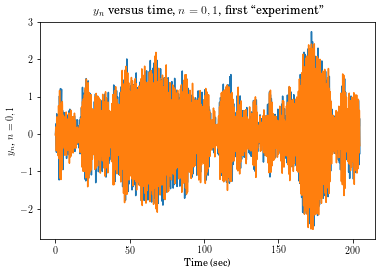

In [49]:
# Simultaneously plot all outputs resulting from the first excitation
# This really makes no practical sense to do... but this is how you do it. 
# Note that we have to swap axes since we want to plot along the 2nd dimension (1)
# but pyplot.plot plots along the first (0th) dimension. The notation used for data 
# mores sense when plotting all outputs on the same dimension in the next cell. 
plt.plot(tin,sp.swapaxes(Yout[:,:,0],0,1))
plt.xlabel('Time (sec)')
plt.ylabel('$y_n$, $n = 0, 1$')
plt.title('$y_n$ versus time, $n = 0, 1$, first ``experiment"')

Text(0.5,1,'$y_0$ versus time, all ``experiments"')

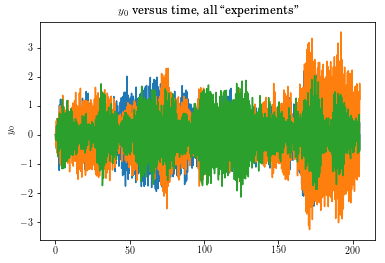

In [50]:
# Simultaneously plot all outputs resulting from the first excitation
plt.plot(tin,Yout[0,:,:])
plt.ylabel('$y_0$')
plt.title('$y_0$ versus time, all ``experiments"')

Text(0.5,1,'$y_1$ versus time, all ``experiments"')

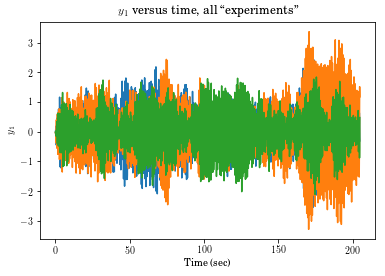

In [51]:
plt.plot(tin, Yout[1,:,:])
plt.xlabel('Time (sec)')
plt.ylabel('$y_1$')
plt.title('$y_1$ versus time, all ``experiments"')

In [54]:
Yout.shape

(2, 2048, 3)

In [55]:
vt.hanning(Yout).shape

(2, 2048, 3)

In [52]:
vt.hanning(Yout[0,:,:]).shape

length = 2
(2048, 3)
Swapping axes temporarily to be compliant with expectations. I'll fix them in your result


(2048, 3)

In [61]:
vt.hanning(Yout)[0,:,:].shape

(2048, 3)

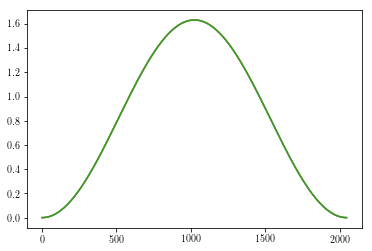

In [58]:
plt.plot(vt.hanning(Yout)[0,:,:])

Text(0.5,1,'Windowed $y_0$ versus time, all ``experiments"')

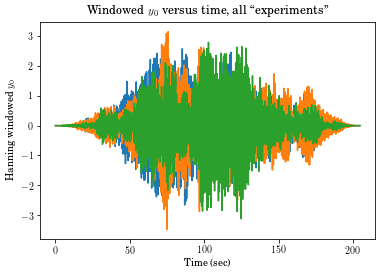

In [62]:
# Here we are windowing the first output. Note that [0,:,:] strips off the first dimension
# If hanning is applied to Yout[0,:,:] it will fail to operate as expected because the first 
# dimension (0) is now the time index, where Hanning expects it to be the second. 
# The code should be improved to allow application to a desired index. For another day...
plt.plot(tin, vt.hanning(Yout)[0,:,:]*Yout[0,:,:])
plt.xlabel('Time (sec)')
plt.ylabel('Hanning windowed $y_0$')
plt.title('Windowed $y_0$ versus time, all ``experiments"')

Text(0,0.5,'Response (all outputs, all experiments)')

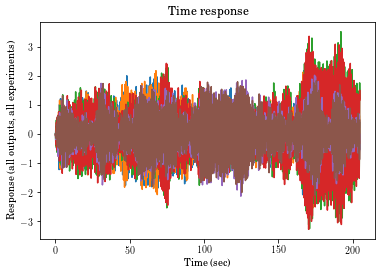

In [63]:
# Note that each layer is a new dataset. Here we plot all 3 datasets on top of each other, 
# numbers 0, 1 and 2, for all outputs

plt.plot(tin,np.transpose(Yout[:,:,0]))
plt.plot(tin,np.transpose(Yout[:,:,1]))
plt.plot(tin,np.transpose(Yout[:,:,2]))
plt.title('Time response')
plt.xlabel('Time (sec)')
plt.ylabel('Response (all outputs, all experiments)')

length = 2
(2, 2048)
length = 2
(2, 2048)
length = 2
(2, 2048)


Text(0,0.5,'Response (all outputs, all experiments)')

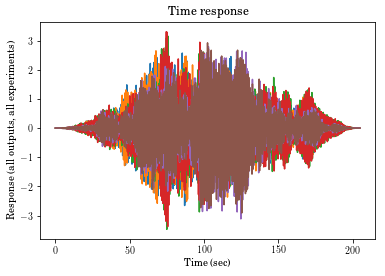

In [64]:
# Note that each layer is a new dataset. Here we plot all 3 datasets on top of each other, 
# numbers 0, 1 and 2

plt.plot(tin,sp.transpose(vt.hanning(Yout[:,:,0])*Yout[:,:,0]))
plt.plot(tin,sp.transpose(vt.hanning(Yout[:,:,1])*Yout[:,:,1]))
plt.plot(tin,sp.transpose(vt.hanning(Yout[:,:,2])*Yout[:,:,2]))
plt.title('Time response')
plt.xlabel('Time (sec)')
plt.ylabel('Response (all outputs, all experiments)')

length = 2
(2048, 3)
Swapping axes temporarily to be compliant with expectations. I'll fix them in your result
length = 2
(2048, 3)
Swapping axes temporarily to be compliant with expectations. I'll fix them in your result


Text(0,0.5,'Response (all outputs, all experiments)')

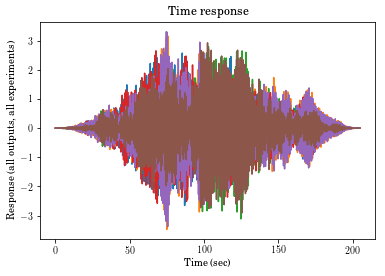

In [65]:
# Note that each layer is a new dataset. Here we plot all 3 datasets on top of each other, 
# numbers 0, 1 and 2

plt.plot(tin,vt.hanning(Yout[0,:,:])*Yout[0,:,:])
plt.plot(tin,vt.hanning(Yout[1,:,:])*Yout[1,:,:])
plt.title('Time response')
plt.xlabel('Time (sec)')
plt.ylabel('Response (all outputs, all experiments)')

You shouldn't do that.
The 1 dimension is the time (or frequency) incrementing dimension.
Swapping axes temporarily to be compliant with expectations.
I'll reluctantly return a transposed result.
You shouldn't do that.
The 1 dimension is the time (or frequency) incrementing dimension.
Swapping axes temporarily to be compliant with expectations.
I'll reluctantly return a transposed result.


Text(0,0.5,'Response (all outputs, all experiments)')

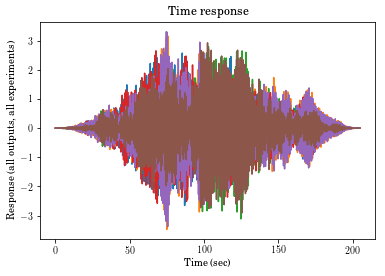

In [66]:
# Note that each layer is a new dataset. Here we plot all 3 datasets on top of each other, 
# numbers 0, 1 and 2

plt.plot(tin,vt.window(Yout[0,:,:], windowname = 'hanning')*Yout[0,:,:])
plt.plot(tin,vt.window(Yout[1,:,:], windowname = 'hanning')*Yout[1,:,:])
plt.title('Time response')
plt.xlabel('Time (sec)')
plt.ylabel('Response (all outputs, all experiments)')

Working up until this point. 

You shouldn't do that.
The 1 dimension is the time (or frequency) incrementing dimension.
Swapping axes temporarily to be compliant with expectations.
I'll reluctantly return a transposed result.


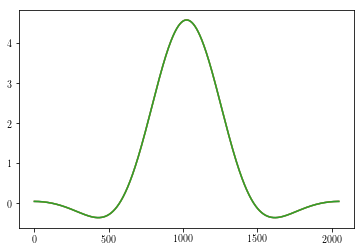

In [67]:
plt.plot(vt.window(Yout[0,:,:], windowname = 'flatwin'))

In [68]:
len(sp.expand_dims(Yout[0,:,:],0).shape)

3

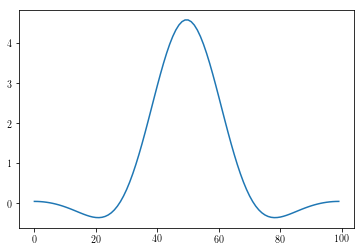

In [69]:
plt.plot(vt.window(100, windowname = 'flatwin'))

In [70]:
N = 50
(0.42-0.5*np.cos(2.*np.pi*(np.arange(N)+.5)/(N))+.08*np.cos(4.*np.pi*(np.arange(N)+.5)/(N)))*np.sqrt(5000/1523)

array([  6.44696791e-04,   5.86783754e-03,   1.66570121e-02,
         3.36658780e-02,   5.77967856e-02,   9.01129953e-02,
         1.31731188e-01,   1.83701668e-01,   2.46884563e-01,
         3.21830713e-01,   4.08675768e-01,   5.07055254e-01,
         6.16047171e-01,   7.34146972e-01,   8.59277831e-01,
         9.88836858e-01,   1.11977570e+00,   1.24871179e+00,
         1.37206445e+00,   1.48620859e+00,   1.58763746e+00,
         1.67312513e+00,   1.73987959e+00,   1.78567749e+00,
         1.80897276e+00,   1.80897276e+00,   1.78567749e+00,
         1.73987959e+00,   1.67312513e+00,   1.58763746e+00,
         1.48620859e+00,   1.37206445e+00,   1.24871179e+00,
         1.11977570e+00,   9.88836858e-01,   8.59277831e-01,
         7.34146972e-01,   6.16047171e-01,   5.07055254e-01,
         4.08675768e-01,   3.21830713e-01,   2.46884563e-01,
         1.83701668e-01,   1.31731188e-01,   9.01129953e-02,
         5.77967856e-02,   3.36658780e-02,   1.66570121e-02,
         5.86783754e-03,

In [18]:
np.cos(np.pi*(np.arange(N)+.5)*1.2)

array([-0.30901699,  0.80901699, -1.        ,  0.80901699, -0.30901699,
       -0.30901699,  0.80901699, -1.        ,  0.80901699, -0.30901699,
       -0.30901699,  0.80901699, -1.        ,  0.80901699, -0.30901699,
       -0.30901699,  0.80901699, -1.        ,  0.80901699, -0.30901699,
       -0.30901699,  0.80901699, -1.        ,  0.80901699, -0.30901699,
       -0.30901699,  0.80901699, -1.        ,  0.80901699, -0.30901699,
       -0.30901699,  0.80901699, -1.        ,  0.80901699, -0.30901699,
       -0.30901699,  0.80901699, -1.        ,  0.80901699, -0.30901699,
       -0.30901699,  0.80901699, -1.        ,  0.80901699, -0.30901699,
       -0.30901699,  0.80901699, -1.        ,  0.80901699, -0.30901699])

In [19]:
Ucomb.shape

(1, 2048, 3)

In [71]:
#Yout=Yout*np.std(Ucomb)/np.std(Yout)#40 I don't recall what this does. Normalizes some amplitudes, clearly.
#plt.title('time response')
#plt.show()
#vt.hanning(Yout)
freq_vec, Pxx = vt.asd(Yout, tin, windowname="hanning", ave=bool(True))
freq_vec, Pyy = vt.asd(Ucomb, tin, windowname="hanning", ave=bool(True))

freq_vec, Pxy = vt.crsd(sp.expand_dims(Yout[0,:,:],0), Ucomb, tin, windowname="hanning", ave=bool(True))
Pxx.shape

(2, 1025)

In [21]:
abs(sp.sqrt(-1))

1.0

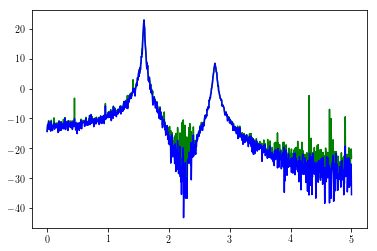

In [72]:
plt.plot(freq_vec,20*sp.log10(abs(Pxx[0,:]/Pxy[0,:])),'-g')
plt.plot(freq_vec,20*sp.log10(abs(Pxy[0,:]/Pyy[0,:])),'-b')

In [73]:
Pxx.shape

(2, 1025)

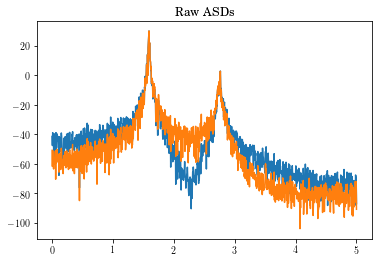

In [80]:
plt.plot(freq_vec, 20*sp.log10(Pxx[:,:].T))
plt.title('Raw ASDs')
plt.show()

(1025,)
(2, 1025)
(2, 1025)


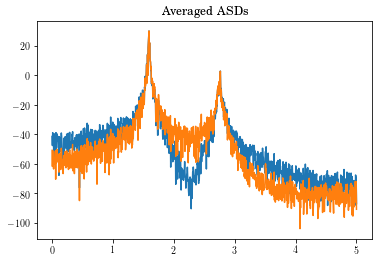

In [82]:
freq_vec, Pxx = vt.asd(Yout, tin, windowname="hanning", ave=bool(True))
print(freq_vec.shape)
print((20*np.log10(Pxx)).shape)
print(Pxx.shape)
plt.plot(freq_vec, 20*np.log10(Pxx).T)
plt.title('Averaged ASDs')
plt.show()

works until here?
(2, 2048, 3)
(1, 2048, 3)


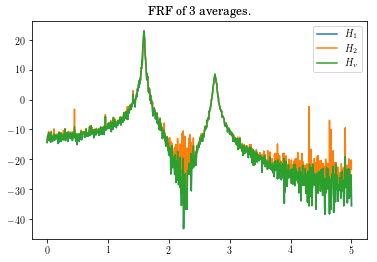

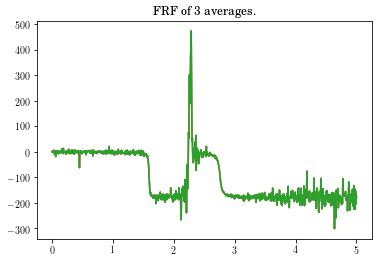

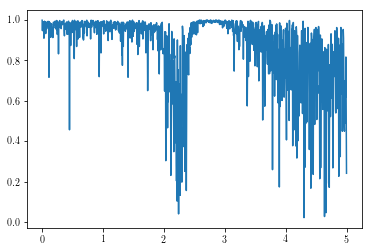

AttributeError: module 'vibrationtesting' has no attribute 'frfplot'

In [85]:
f, Txy1, Txy2, coh, Txyv = vt.frfest(Yout, Ucomb, t, Hv=bool(True))
#fig_amp,=plt.plot(f[0,:],20*np.log10(np.abs(Txy1[0,:])),legend='$H_1$',f[0,:],20*np.log10(np.abs(Txy2[0,:])),legend='$H_2$',f[0,:],20*np.log10(np.abs(Txyv[0,:])),legend='$H_v$')
(line1, line2, line3) = plt.plot(f,20*np.log10(np.abs(Txy1[0,:])),f,20*np.log10(np.abs(Txy2[0,:])),f,20*np.log10(np.abs(Txyv[0,:]))) 
plt.title('FRF of ' + str(Yout.shape[2]) + ' averages.')
plt.legend((line1,line2,line3),('$H_1$','$H_2$','$H_v$'))
plt.show()
plt.plot(f,180.0/np.pi*np.unwrap(np.angle(Txy1[0,:])),f,180.0/np.pi*np.unwrap(np.angle(Txy2[0,:])),f,180.0/np.pi*np.unwrap(np.angle(Txyv[0,:]))) 
plt.title('FRF of ' + str(Yout.shape[2]) + ' averages.')
plt.show()
plt.plot(f,coh[0,:])
plt.show()
vt.frfplot(f,Txy1,freq_max=3.5)

In [ ]:
freq_vec.shape


In [ ]:
plt.plot(freq_vec, 20*np.log10(Pxx))

In [ ]:
Pxx.shape

In [ ]:
vt.hanning(Yout[:,:,0]).shape

In [ ]:
np.linspace(0,1,4).shape

In [ ]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import vttools as vt
from numpy import linalg
sample_freq = 1e3
tfinal = 5
sig_freq=1#50
A=10
noise_power = 0.0001 * sample_freq / 2
noise_power = A/1e2
time = np.arange(0,tfinal,1/sample_freq)
x = A*np.sin(2*np.pi*sig_freq*time)
print(x.shape)
x_sig = x + np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
print(x_sig.shape)
plt.subplot(2,1,1)
plt.plot(time,x_sig)
plt.title('Time history')
plt.xlabel('Time (sec)')
plt.ylabel('$x(t)$')
freq_vec, Pxx = vt.asd(x, time, window="hanning", ave=bool(False))
plt.subplot(2,1,2)
#plt.plot(freq_vec[0,:], 20*np.log10(Pxx[0,:,:]))
plt.ylim([-400, 100])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [ ]:
x_sig.shape


In [ ]:
import vttools as vt

In [ ]:
vt.hanning(4).shape

In [ ]:
a=vt.hanning(5)

win=vt.hanning(a)


In [ ]:
import numpy as np

In [ ]:
print('reshape is NOT what you want. You want SWAPAXES')
b = np.hstack((np.reshape(a,(-1,1)),np.reshape(a,(-1,1))))


In [ ]:
b.shape

In [ ]:
win2 = vt.hanning(b)

In [ ]:
win2.shape

In [ ]:
c=np.dstack((b,b))

In [ ]:
c

In [ ]:
win3=vt.hanning(c)

In [ ]:
win3.shape

In [ ]:
win3

In [46]:
vt.window(np.linspace(0,10).reshape(-1,1)).shape

You shouldn't do that.
The 1 dimension is the time (or frequency) incrementing dimension.
Swapping axes temporarily to be compliant with expectations.
I'll reluctantly return a transposed result.


(50, 1)

In [87]:
help(vt.frfest)

Help on function frfest in module vibrationtesting.sigp:

frfest(x, f, dt, window='hanning', ave=True, Hv=False)
    returns freq, H1, H2, coh, Hv
    
    Estimates the :math:`H(j\omega)` Frequency Response Functions (FRFs) between :math:`x` and :math:`f`.
    
        - parameters using ``:param <name>: <description>``
        - type of parameters ``:type <name>: <description>``
        - returns using ``:returns: <description>``
        - examples (doctest)
        - seealso using ``.. seealso:: text``
        - notes using ``.. note:: text``
        - warning using ``.. warning:: text``
        - todo ``.. todo:: text``
    
    
    :param x: output or response of system
    :param f: input to system
    :param dt: time step or time array
    :param window: name of data window to apply
    :param ave: apply averaging
    :param Hv: calculate :math:`H_v` Frequency Response Function Estimation
    :type x: float array
    :type f: float array
    :type dt: float
    :type window: st

In [103]:
del Yout
sample_freq = 1e3
noise_power = 0.001 * sample_freq / 2
A = np.array([[0, 0, 1, 0], [0, 0, 0, 1], [-200, 100, -.2, .1], [100, -200, .1, -.2]])
B = np.array([[0], [0], [1], [0]])
C = np.array([[35, 0, 0, 0], [0, 35, 0, 0]])
D = np.array([[0], [0]])
sys = ctrl.ss(A, B, C, D)
tin = np.arange(0, 51.2, .1)
nr=.5   # 0 is all noise on input
for i in np.arange(5): #was 2*50
    u = np.random.normal(scale=np.sqrt(noise_power), size=tin.shape)
    #print(u)
    t, yout, xout = ctrl.forced_response(sys, tin, u,rtol=1e-12)#,transpose=True)
    if 'Yout' in locals():
        Yout=np.dstack((Yout,yout+nr*np.random.normal(scale=.050*np.std(yout[0,:]), size=yout.shape)))
        Ucomb=np.dstack((Ucomb,u+(1-nr)*np.random.normal(scale=.05*np.std(u), size=u.shape)))
    else:
        Yout=yout+nr*np.random.normal(scale=.050*np.std(yout[0,:]), size=yout.shape) # 5% half the noise on output as on input
        Ucomb=u+(1-nr)*np.random.normal(scale=.05*np.std(u), size=u.shape)#(1, len(tin))) #10% noise signal on input

In [104]:
Yout.shape

(2, 512, 5)

In [105]:
Ucomb.shape

(1, 512, 5)

In [106]:
f, Txy1, Txy2, coh, Txyv = vt.frfest(Yout, Ucomb, t,Hv=bool(True))

(1, 512, 5)
(1, 257, 5)
(1, 512, 5)
(1, 257, 5)
works until here?
(2, 512, 5)
(1, 512, 5)
(1, 512, 5)
(1, 257, 5)
(2, 512, 5)
(2, 257, 5)
(2, 512, 5)
(2, 257, 5)
(2, 512, 5)
(2, 257, 5)


In [99]:
Yout.shape

(512, 2, 5)